In [248]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

import pywavefront
import numpy as np

import os
import sys
import rclpy
if '/home/paul/CLionProjects/thesis_nerf/scripts' not in sys.path:
    sys.path.append('/home/paul/CLionProjects/thesis_nerf/scripts')
if not rclpy.ok():
    rclpy.init()
from point_cloud_utils import send_point_cloud
    

def send_points(points, color, topic):
    colors = np.zeros(points.shape)+color 
    rgb_points = np.hstack((points, colors))
    send_point_cloud(rgb_points, has_alpha=False,topic=topic)
    
def get_vert_np():
#     obj = 'truck.obj'
#     obj = 'block.obj'
#     obj = 'monkey.obj'
    obj = 'long.obj'
    scene = pywavefront.Wavefront(obj, parse=True)
    return np.array(scene.vertices)

vert_np = get_vert_np()
num_grid_dim = int((vert_np.shape[0]//np.sqrt(vert_np.shape[0])))
ind = num_grid_dim**2
vert_np = vert_np[:ind,:]
vert_np = vert_np -np.mean(vert_np, axis=0)
verts = torch.tensor(vert_np,dtype=torch.float32, device='cuda')

zeros = np.zeros((vert_np.shape[0]*0, vert_np.shape[1]))
vert_zero = torch.tensor(np.vstack((vert_np, zeros)), dtype=torch.float32, device='cuda')
target_ones = np.ones((vert_np.shape[0], 1))
target_zeros = np.zeros((zeros.shape[0], 1))

target_value = torch.tensor(np.vstack((target_ones, target_zeros)), dtype=torch.float32, device='cuda')



x = np.linspace(0, 1, num_grid_dim)
y = np.linspace(0, 1, num_grid_dim)
xv, yv = np.meshgrid(x, y, indexing='xy')
verts_grid = torch.tensor(np.stack((xv.flatten(), yv.flatten()), axis=1), dtype=torch.float32, device='cuda')

Unimplemented OBJ format statement 's' on line 's 0'


In [249]:
np.mean(vert_np, axis=0)

array([-2.30470405e-17,  6.43794825e-17, -3.75266711e-18])

In [253]:


class MeshNet(nn.Module):
    def __init__(self):
        super(MeshNet, self).__init__()
        self.num_dims = 3
        self.num_basis = 9
        self.dt = 0.1
        self.num_steps = 2
        self.fcs = []
        for ind in range(self.num_steps):
#             fc = nn.Linear(self.num_basis*self.num_dims+self.num_dims, self.num_dims)
            fc = nn.Linear(3**3+self.num_dims, self.num_dims)
            setattr(self, f'fc_{ind}', fc)
            self.fcs.append(fc)
        
        self.scale = nn.Parameter(torch.ones(1,1, dtype=torch.float32, device='cuda'))
        self.offset = nn.Parameter(torch.zeros(1, 3, dtype=torch.float32, device='cuda'))
         
    def forward(self, x):
        x = 1*x
        x = self.offset + x
        x = self.scale*x
        for fc in self.fcs:
#             features = [x]
#             features.extend([torch.sin(.02*3.14*i*x) for i in range(1, self.num_basis+1, 1)])
            features = [x]
            features.extend([torch.reshape((x[:,0]**(xn+2))*(x[:,1]**(yn+2))*(x[:,2]**(zn+2)), (-1,1)) for xn in range(3) for yn in range(3) for zn in range(3)])
#             print(features)
            features = torch.concatenate(features, axis=1)
            x = x + torch.tanh(fc(features))*self.dt
#             x = x + (fc(features))*self.dt
            

       
        
        value = torch.sqrt(torch.sum(x**2, axis=1))
        points = x
        return value, points 
        
        
def compute_loss(pred_value, pred_points, target_value):
    loss = F.huber_loss(pred_value, target_value)
    tmp = torch.ones(1, 3, dtype=torch.float32, device='cuda')
    m_max,_ = pred_points.max(axis=0)
    m_min,_ = pred_points.min(axis=0)
    loss = loss + 1*F.huber_loss(m_max, tmp)
    loss = loss +  1*F.huber_loss(m_min, -tmp)
    
#     loss = (abs(pred_value - target_value)).sum()/pred_value.shape[0]
    return loss
    
network = MeshNet()
network.cuda(device='cuda')

MeshNet(
  (fc_0): Linear(in_features=30, out_features=3, bias=True)
  (fc_1): Linear(in_features=30, out_features=3, bias=True)
)

In [ ]:
lr = 1e-1 #huber
# lr = 1e-5 # abs
momentum = 0.9



optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)

for it in range(0, 20000):
    optimizer.zero_grad()
    pred_value, pred_points = network(vert_zero)
    loss_train = compute_loss(pred_value=pred_value, pred_points=pred_points, target_value=target_value)
    if it % 100== 0:
        print(loss_train)
        pred_points_np = pred_points.cpu().detach()
        send_points(pred_points_np, np.array([0,1,0]),topic='point_cloud_2')
        send_points(vert_np, np.array([.7,.7,.7]),topic='point_cloud')
    loss_train.backward()
    optimizer.step()
    
    
    

/tmp/ipykernel_40528/134972005.py:41: UserWarning: Using a target size (torch.Size([784, 1])) that is different to the input size (torch.Size([784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.huber_loss(pred_value, target_value)
/tmp/ipykernel_40528/134972005.py:45: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss + 1*F.huber_loss(m_max, tmp)
/tmp/ipykernel_40528/134972005.py:46: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss +  1*F.huber_loss(m_min, -tmp)


tensor(1.0750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)


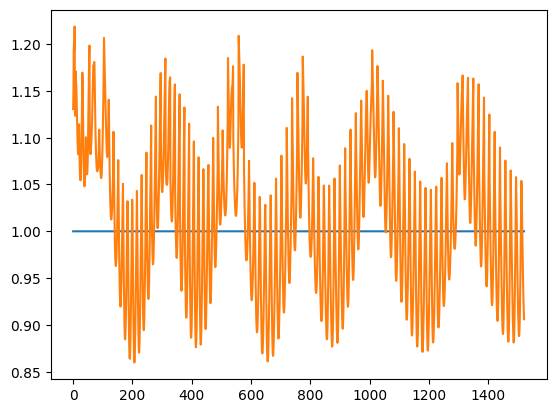

In [239]:
from matplotlib.pyplot import plot as plot

plot((target_value).cpu().detach().numpy())
plot((pred_value).cpu().detach().numpy())

torch.return_types.min(
values=tensor([ 0.0394,  0.9028, -0.4227], device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor([3812, 3812, 3717], device='cuda:0'))